In [26]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Підвищимо розмір графіків за замовчуванням
# plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['figure.figsize'] = 7, 5
# plt.rcParams['axes.grid'] = True


In [27]:
# Initialize variables
DATASET_NAME = 'adfes'
PALETTE_BARPLOT = 'Blues'
PALETTE_HEATMAP = 'Blues'

# Define emotion classes
EMOTIONS = ['Злість', 'Страх', 'Радість', 'Нейтр.', 'Сум']

# Define used metrics
METRICS = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Sheet names
SHEET_NAMES = ['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5']

# Dictionary to hold arrays
input_matrices = {}

# Read each sheet and convert to numpy array
for i, sheet in enumerate(SHEET_NAMES, start=1):
    df = pd.read_excel(f'{DATASET_NAME}_experiments.xlsx', sheet_name=sheet)
    input_matrices[f'Модель_{i}'] = df.to_numpy()

# Access the numpy array for a specific matrix
# print(input_matrices)


In [28]:
# Dataframe to hold the results
df_results = pd.DataFrame()

# Iterate over each confusion matrix
for matrix_name, A in input_matrices.items():

    # Calculate accuracy
    accuracy = np.trace(A) / np.sum(A)

    # Flatten the matrix for sklearn metrics
    y_true = np.repeat(np.arange(A.shape[0]), np.sum(A, axis=1))
    y_pred = np.repeat(np.arange(A.shape[0]), np.sum(A, axis=0))

    # Calculate precision, recall and f1-score independently for each class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f_score = f1_score(y_true, y_pred, average=None)

    # Create a dataframe from the metrics
    df = pd.DataFrame({
        'Emotion': EMOTIONS,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f_score
    })

    # Add accuracy column (same value for each class)
    df['Accuracy'] = accuracy

    # Add matrix name column
    df['Model'] = matrix_name

    # Append this dataframe to the results dataframe
    df_results = df_results.append(df, ignore_index=True)

# Set the Matrix and Emotion columns as the index
# df_results.set_index(['Matrix', 'Emotion', 'Precision', 'Recall', 'F1-Score', 'Accuracy'], inplace=True)

# Save the DataFrame to an Excel file
df_results.to_excel(f'{DATASET_NAME}_results.xlsx')

# Save the DataFrame to a csv file
df_results.to_csv(f'{DATASET_NAME}_results.csv')

# Print the dataframe
# df_results


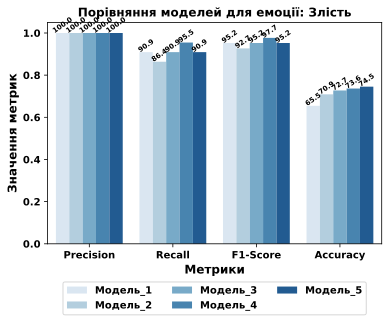

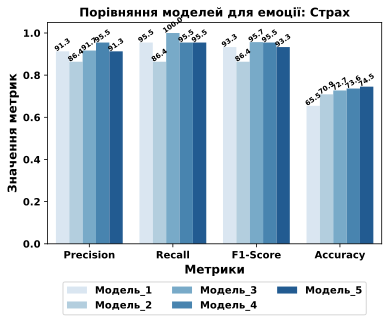

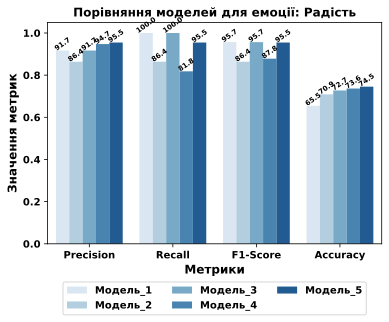

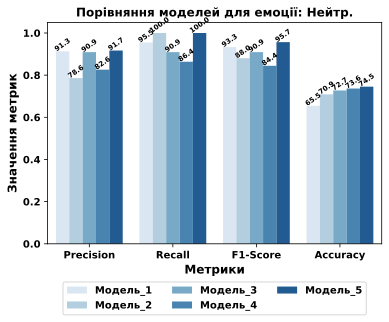

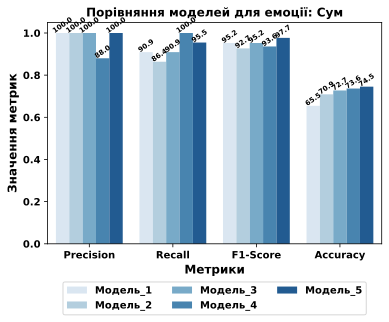

In [29]:
# Get unique emotions
emotions = df_results['Emotion'].unique()

# loop over each emotion
for emotion in emotions:
    # Filter rows for the current emotion
    df_emotion = df_results[df_results['Emotion'] == emotion]

    # Melt the DataFrame to long format for easy plotting with seaborn
    # emotion_data_melt = pd.melt(emotion_data, id_vars=['Matrix', 'Emotion'],
    #                             value_vars=['Precision', 'Recall', 'F1-Score', 'Accuracy'])
    
    df_emotion_melted = df_emotion.melt(id_vars='Model', value_vars=METRICS, 
                                        var_name='Metric', value_name='Value')
    
    # Plot the data
    plt.figure(figsize=(6,4), dpi=600)
    plt.rcParams.update({
        'font.size': 10,
        'font.weight': 'bold'})
    
    # Plot the barplot 
    barplot = sns.barplot(x='Metric', y='Value', hue='Model', ci=None, 
                          data=df_emotion_melted, 
                          palette=PALETTE_BARPLOT)

    # Add title and labels
    plt.title(f'Порівняння моделей для емоції: {emotion}', fontweight='bold', fontsize=12)
    plt.ylabel('Значення метрик', fontweight='bold', fontsize=12)
    plt.xlabel('Метрики', fontweight='bold', fontsize=12)

    # Move the legend to an empty part of the plot
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', 
               ncol=3, fontsize=10)
    
    # Plot data labels
    for p in barplot.patches:
        height = p.get_height()
        barplot.text(x = p.get_x()+(p.get_width()/2),
                     y = height,
                     s = '{:.1f}'.format(height*100),
                     ha = 'center',
                     rotation=35, 
                     fontsize=7)
    
    # Check if the folder exists
    if not os.path.exists(f'{DATASET_NAME}_barplots'):
        os.makedirs(f'{DATASET_NAME}_barplots')
    
    # Save the plot
    plt.savefig(f'{DATASET_NAME}_barplots/{DATASET_NAME}_bp_{emotion}.svg', 
                format='svg', bbox_inches='tight')
    
    # Show the plot
    plt.show()


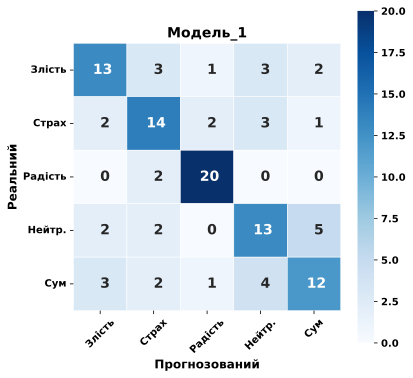

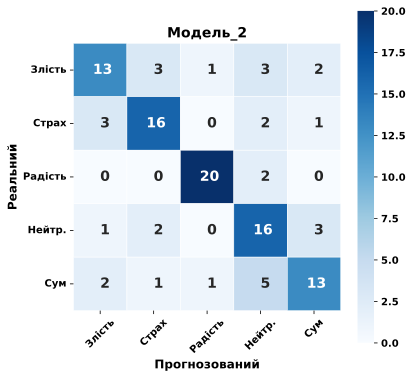

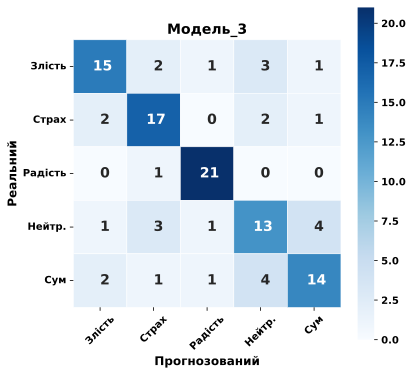

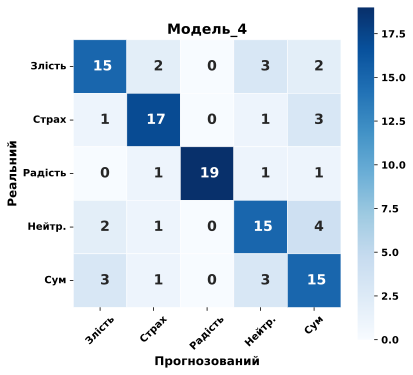

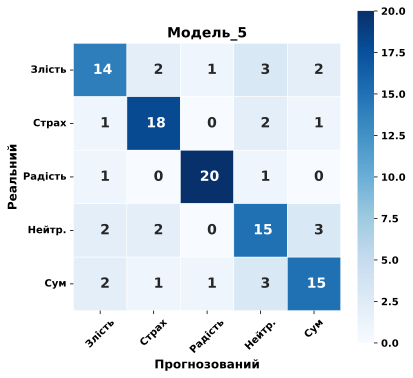

In [30]:
# Loop over each matrix and plot it
for matrix_name, matrix in input_matrices.items():
    plt.figure(figsize=(6,6), dpi=600)

    sns.heatmap(matrix, cmap=PALETTE_HEATMAP, annot=True, xticklabels=EMOTIONS, 
                yticklabels=EMOTIONS, annot_kws={"size": 14, "weight": "bold"}, 
                fmt='3g', square=True, linewidths=0.5, cbar_kws={"shrink": 1.0})

    # plt.tick_params(axis='x', labelsize=12) # x font label size
    # plt.tick_params(axis='y', labelsize=12) # y font label size

    plt.yticks(fontweight='bold', fontsize=10, rotation=0)
    plt.xticks(fontweight='bold', fontsize=10, rotation=45)

    plt.title(matrix_name, fontweight='bold', fontsize=14)
    plt.ylabel('Реальний', fontweight='bold', fontsize=12)
    plt.xlabel('Прогнозований', fontweight='bold', fontsize=12)
        
    if not os.path.exists(f'{DATASET_NAME}_heatmaps'):
        os.makedirs(f'{DATASET_NAME}_heatmaps')
    
    # Save the plot
    # plt.savefig(f'heatmaps/heatmap_{matrix_name}.png', dpi=600, bbox_inches='tight')
    plt.savefig(f'{DATASET_NAME}_heatmaps/{DATASET_NAME}_hm_{matrix_name}.svg', 
                format='svg', bbox_inches='tight')
    
    # Show the plot
    plt.show()
